# Lets import some things

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
import time
from torchsummary import summary
import scipy.io

In [2]:
mat = scipy.io.loadmat('data/flowers-102/imagelabels.mat')
print(len(mat['labels'][0])) #it turns out the image labels are numbers and i cant recognise flowers by eye. nvm i found someone helpful online

8189


# I found a text file with the classnames

In [3]:
names = [ 'pink primrose','hard-leaved pocket orchid','canterbury bells','sweet pea','english marigold','tiger lily','moon orchid','bird of paradise','monkshood','globe thistle','snapdragon',"colt's foot",'king protea','spear thistle','yellow iris','globe-flower','purple coneflower','peruvian lily','balloon flower','giant white arum lily','fire lily','pincushion flower','fritillary','red ginger','grape hyacinth','corn poppy','prince of wales feathers','stemless gentian','artichoke','sweet william','carnation','garden phlox','love in the mist','mexican aster','alpine sea holly','ruby-lipped cattleya','cape flower','great masterwort','siam tulip','lenten rose','barbeton daisy','daffodil','sword lily','poinsettia','bolero deep blue','wallflower','marigold','buttercup','oxeye daisy','common dandelion','petunia','wild pansy','primula','sunflower','pelargonium','bishop of llandaff','gaura','geranium','orange dahlia','pink-yellow dahlia?','cautleya spicata','japanese anemone','black-eyed susan','silverbush','californian poppy','osteospermum','spring crocus','bearded iris','windflower','tree poppy','gazania','azalea','water lily','rose','thorn apple','morning glory','passion flower','lotus','toad lily','anthurium','frangipani','clematis','hibiscus','columbine','desert-rose','tree mallow','magnolia','cyclamen ','watercress','canna lily','hippeastrum ','bee balm','ball moss','foxglove','bougainvillea','camellia','mallow','mexican petunia','bromelia','blanket flower','trumpet creeper','blackberry lily']

# Decide if cuda

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True

cuda


# Load dataset

In [5]:
trainingData = datasets.Flowers102(
    root="data",
    split = "train",
    download = True,
    transform = transforms.Compose([
        transforms.RandomResizedCrop((256, 256),scale=(0.85,1.0),),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), 
        transforms.ColorJitter(contrast=0.1,brightness=0.1, saturation=0.1,hue=0.05),#becaise the dataset will evidently be sensitve to colour might want to avoid this one
        # transforms.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9,1.1),shear=0.15),
        # transforms.GaussianBlur(kernel_size=(2,2),sigma=(0.1,0.8)),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.432, 0.381, 0.296], [0.258,  0.209, 0.221] )
    ])
)
testData = datasets.Flowers102(
    root="data",
    split= "test",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.432, 0.381, 0.296], [0.258,  0.209, 0.221] )
    ])
)
valData = datasets.Flowers102(
    root="data",
    split = "val",
    download = True,
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.432, 0.381, 0.296], [0.258,  0.209, 0.221] )
    ])
)

C:\Users\James\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
print(f'training data has: {len(trainingData)} images')
print(f'validation data has: {len(valData)} images')
print(f'test data has: {len(testData)} images')

training data has: 1020 images
validation data has: 1020 images
test data has: 6149 images


# Neural Network class

In [7]:
class NeuralNet(nn.Module):
    def __init__(self,num_classes):
        super(NeuralNet, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3, 64, kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #2
            nn.Conv2d(64,128,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #3
            nn.Conv2d(128,256,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #4
            nn.Conv2d(256,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            #5
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #6
            nn.Conv2d(512,512,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2)
        )
        
        self.classifier = nn.Sequential(
            #7
            nn.Linear(4*4*512,4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            #8
            nn.Linear(4096,num_classes), 
            # nn.Softmax(dim=1)
            nn.ReLU(inplace=True),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))#6.5
        
    def forward(self, x):
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x= self.classifier(x)
        return x

# Training loop

In [8]:
def train(model, train_dataloader, val_dataloader, num_epochs, learning_rate, device):
    cost = nn.CrossEntropyLoss(label_smoothing=0.2).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.89, weight_decay=0.002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, factor=0.8, mode='min')
    
    best_val_acc = 0.0
    best_epoch = 0
    
    loss_per_epoch = []
    val_epochs = []
    tra_epochs = []
    quit_early_counter = 0
    last_epoch_loss = None
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        batches = 0
        
        for i, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = cost(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batches += 1
        
        avg_loss = running_loss / batches
        loss_per_epoch.append(avg_loss)
        
        val_acc, val_avg_loss = evaluate(model=model, dataloader=val_dataloader, device=device, cost=cost)
        val_epochs.append(val_acc)
        tra_acc, train_avg_loss = evaluate(model=model, dataloader=train_dataloader, device=device, cost=cost)
        tra_epochs.append(tra_acc)
        
        scheduler.step(val_avg_loss)
        
        
        
        if last_epoch_loss is not None and abs(last_epoch_loss - avg_loss) < 0.01:
            quit_early_counter += 1
        else:
            quit_early_counter = 0
        last_epoch_loss = avg_loss
        
        epoch_length = time.time() - epoch_start
        
        print(f'\nEpoch: {epoch+1}, Num Batches: {batches}, Avg Loss: {avg_loss:.4f}, Epoch Took: {epoch_length:.1f}s, Validation: {val_acc:.3f}% acc, {val_avg_loss:.3f} loss, Training: {tra_acc:.3f}% acc, {train_avg_loss:.3f} loss')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            save(model, "best_model_checkpoint")
        
        if quit_early_counter >= 5:
            print('Validation accuracy hasn\'t improved over the last 5 epochs. Stopping training.')
            break
        if tra_acc == 100:
            print('Model converged to 100% accuracy on training data. Stopping training.')
            break
    
    print(f'Best validation accuracy: {best_val_acc:.3f}% at epoch {best_epoch+1}')
    print(f'Average loss: {avg_loss:.4f}, Training accuracy: {tra_acc:.3f}%, Validation accuracy: {val_acc:.3f}%')
    
    load(model, "best_model_checkpoint", device)  # Load the best model checkpoint
    all_eval(model=model, device=device, cost=nn.CrossEntropyLoss())  # Evaluate based on the best validation accuracy
    
    return np.array(loss_per_epoch), np.array(val_epochs), np.array(tra_epochs)


# Plot the avg loss against epochs

In [9]:
def plot_array(array,name):
    plt.plot(array, label=f'{name}')  
    plt.legend()
    plt.show()

# Display the training, testing, validation accuracy

In [10]:
def evaluate(model, dataloader, device, cost):
    model.eval()
    correct = 0
    total =0
    total_loss =0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            total_loss += loss.item() *labels.size(0)
        acc= 100 *correct/total
        avg_loss = total_loss/total
    return acc, avg_loss

# evaluate on test, validation and training data

In [11]:
def all_eval(model, device, cost):
    accval, _= evaluate(model=model,dataloader=val_dataloader,device=device,cost=cost)
    print(f'val acc: {accval:.3f}%')
    acctest, _ = evaluate(dataloader=test_dataloader,model=model,cost=cost,device=device)
    print(f'test acc: {acctest:.3f}%')
    trainacc, _ = evaluate(dataloader=train_dataloader,model=model,cost=cost,device=device)
    print(f'train acc: {trainacc:.3f}%')

# Save model

In [12]:
def save(model, pathname):
    torch.save(model.state_dict(), f'{pathname}.pth')
    print(f'Saved model to {pathname}.pth')

# Load model

In [13]:
def load(model, pathname ,device):
    model.load_state_dict(torch.load(f'{pathname}.pth'))
    model.to(device)
    print(f'Loaded model from {pathname}.pth')

# Visualise samples

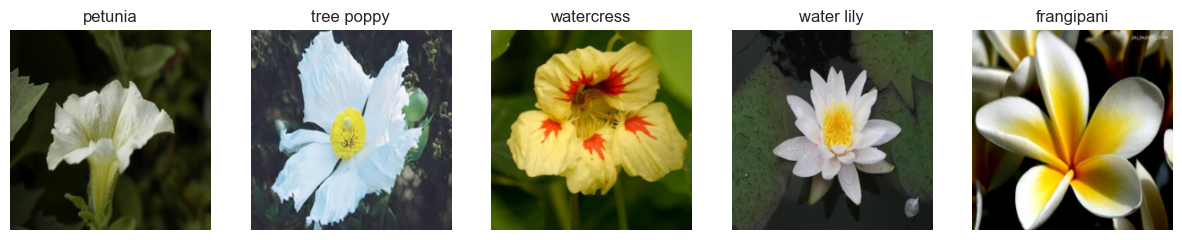

In [14]:
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        # Randomly select a sample from the dataset
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[sample_idx]

        # Denormalize the image
        image = image * torch.tensor([0.258,  0.209, 0.221]).view(3, 1, 1) + torch.tensor([0.432, 0.381, 0.296]).view(3, 1, 1) #[0.258,  0.209, 0.221]
        #[0.432, 0.381, 0.296]
        # Plot the image
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f'{names[label]}')
        axes[i].axis('off')

    plt.show()

# Visualize samples from the test dataset, something for sanity really
visualize_samples(testData)

# main loop

# runs a command that converts this notebook to a py script

In [16]:
def convert():
    !jupyter nbconvert --to script Classifier.ipynb

In [17]:
convert()

[NbConvertApp] Converting notebook Classifier.ipynb to script
[NbConvertApp] Writing 12792 bytes to Classifier.py


# todo: sanity checker for top-k

# Sanity checking

In [18]:
def plot_pred(dataset, ):
    fig, axes = plt.figure() 
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    image, label = dataset[sample_idx]
    
    
    
    
    plt.show()